In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pdb
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold


sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings

from loaders import load_sabes
#from decoders import lr_decoder


In [3]:
decoders = [{'trainlag': 4, 'testlag': 4, 'decoding_window':5},
            {'trainlag': 2, 'testlag': 2, 'decoding_window':5},
            {'trainlag': 6, 'testlag': 6, 'decoding_window':5},
            {'trainlag': 0, 'testlag': 0, 'decoding_window':5}]
loader_args = [{'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'M1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'},
               {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':0, 'region':'S1'},
               {'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':0, 'region':'S1'},
               {'bin_width':100, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'}]

### Decoding

In [5]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-lear

In [6]:
sabes_df = pd.DataFrame(result_list)
indy_df = pd.DataFrame(rl2)

In [7]:
# This guy has good decoding
data_files = np.unique(sabes_df['data_file'].values)[6]

In [8]:
data_files

'loco_20170227_04.mat'

In [9]:
data_files = np.unique(sabes_df['data_file'].values)
dims = np.unique(sabes_df['dim'].values)
r2fc = np.zeros((len(data_files), 20, dims.size, 5, 3))

for i, data_file in tqdm(enumerate(data_files)):
    for idx, (decoder_arg, loader_arg) in enumerate(itertools.product(decoders, loader_args)):
        for j, dim in enumerate(dims):               
            for f in range(5):
                dim_fold_df = apply_df_filters(sabes_df, data_file=data_file, loader_args=loader_arg, decoder_args=decoder_arg, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
                # Trace loss
                try:
                    assert(dim_fold_df.shape[0] == 1)
                except:
                    r2fc[i, idx, j, f, :] = np.nan
                    continue
                r2fc[i, idx, j, f, :] = dim_fold_df.iloc[0]['r2']

dims = np.unique(sabes_df['dim'].values)
r2pca = np.zeros((len(data_files), 20, dims.size, 5, 3))

for i, data_file in enumerate(data_files):
    for idx, (decoder_arg, loader_arg) in enumerate(itertools.product(decoders, loader_args)):
        for j, dim in enumerate(dims):
            for f in range(5):
                dim_fold_df = apply_df_filters(sabes_df, data_file=data_file, loader_args=loader_arg, decoder_args=decoder_arg, dim=dim, fold_idx=f, dimreduc_method='PCA')
                # Trace loss
                try:
                    assert(dim_fold_df.shape[0] == 1)
                except:
                    r2pca[i, idx, j, f, :] = np.nan
                    continue                   
                r2pca[i, idx, j, f, :] = dim_fold_df.iloc[0]['r2']

10it [05:26, 32.60s/it]


In [10]:
dims = np.unique(sabes_df['dim'].values)
ifcr2 = np.zeros((2, dims.size, 5, 3))
ipcr2 = np.zeros((2, dims.size, 5, 3))
for j, dim in enumerate(dims):               
    for f in range(5):
        dim_fold_df = apply_df_filters(indy_df, dim=dim, fold_idx=f, dimreduc_method='LQGCA')
        assert(dim_fold_df.shape[0] == 1)
        ifcr2[1, j, f] = dim_fold_df.iloc[0]['r2']

        dim_fold_df = apply_df_filters(indy_df, dim=dim, fold_idx=f, dimreduc_method='PCA')
        assert(dim_fold_df.shape[0] == 1)
        ipcr2[1, j, f] = dim_fold_df.iloc[0]['r2']

In [7]:
# with open('r2_array.dat', 'wb') as f:
#     f.write(pickle.dumps(r2fc))
#     f.write(pickle.dumps(r2pca))
with open('r2_array.dat', 'rb') as f:
    r2fc = pickle.load(f)
    r2pca = pickle.load(f)

In [12]:
[data_files[0], data_files[1], data_files[3], data_files[6], data_files[7], data_files[8], data_files[9]] 

['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat']

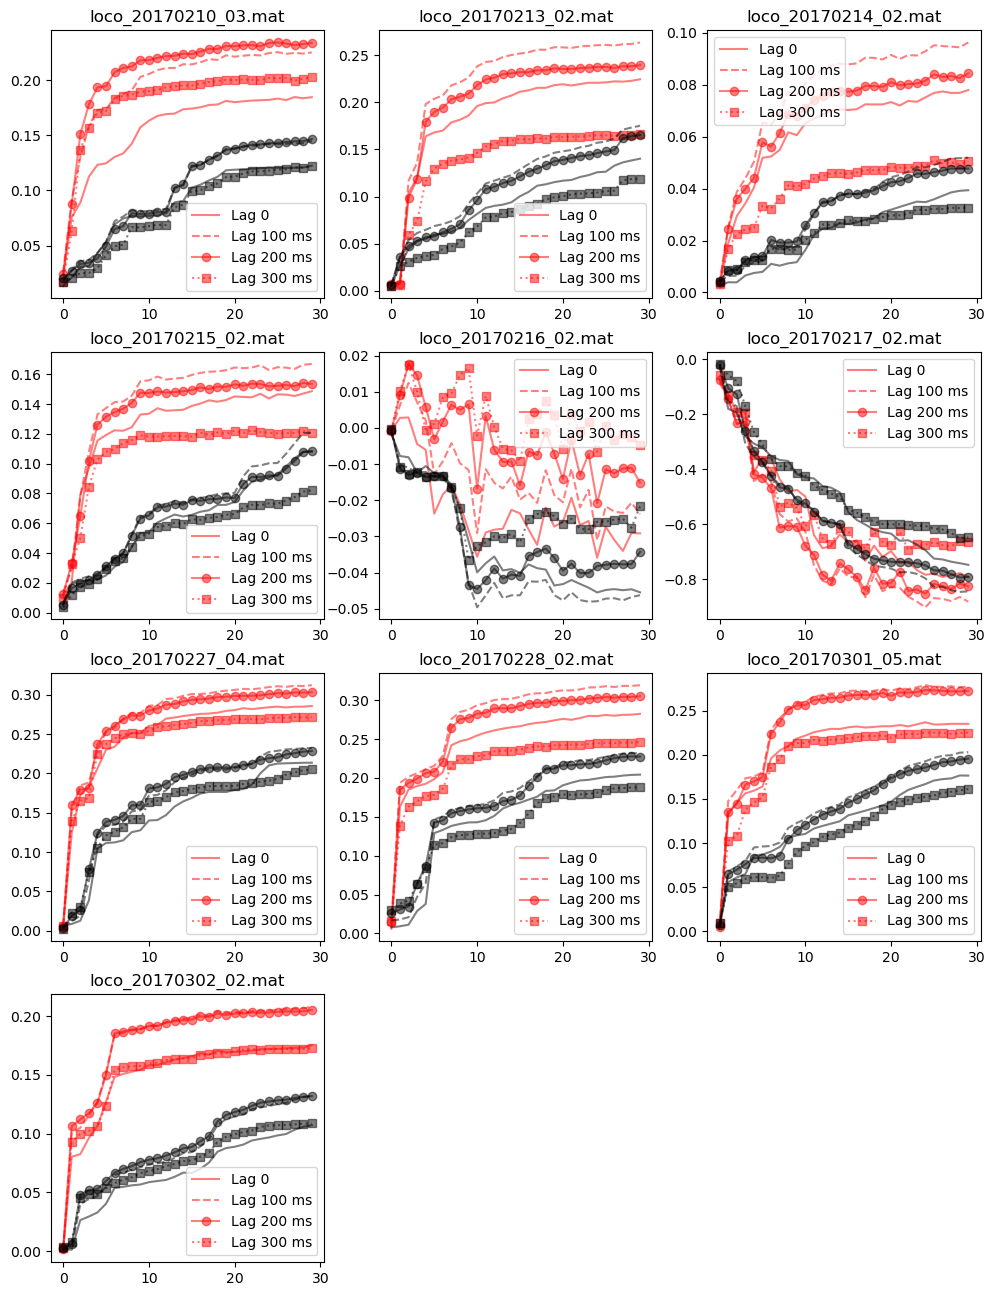

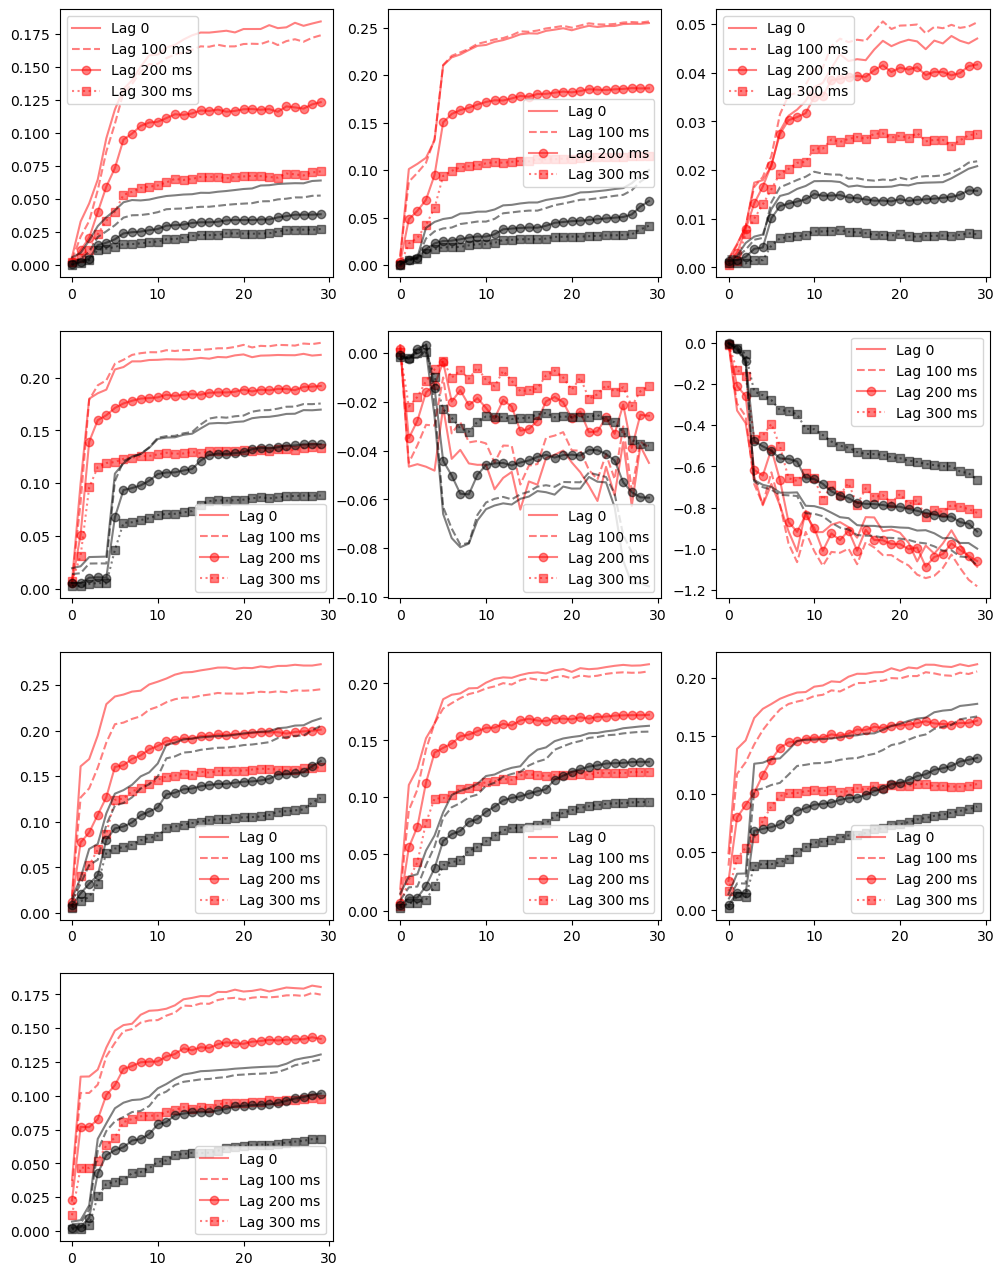

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(12, 16))

# M1
for i in range(10):
    a = ax[np.unravel_index(i, (4, 3))]
    a.plot(np.mean(r2fc[i, 15, :, :, 1], axis=1), color='r', linestyle='-', alpha=0.5)
    a.plot(np.mean(r2fc[i, 5, :, :, 1], axis=1), color='r', linestyle='--', alpha=0.5)
    a.plot(np.mean(r2fc[i, 0, :, :, 1], axis=1), color='r', marker='o', alpha=0.5)
    a.plot(np.mean(r2fc[i, 10, :, :, 1], axis=1), color='r', marker='s', linestyle=':', alpha=0.5)
    a.legend(['Lag 0', 'Lag 100 ms', 'Lag 200 ms',  'Lag 300 ms'])

    a.plot(np.mean(r2pca[i, 15, :, :, 1], axis=1), color='k', linestyle='-', alpha=0.5)
    a.plot(np.mean(r2pca[i, 5, :, :, 1], axis=1), color='k', linestyle='--', alpha=0.5)
    a.plot(np.mean(r2pca[i, 0, :, :, 1], axis=1), color='k', marker='o', alpha=0.5)
    a.plot(np.mean(r2pca[i, 10, :, :, 1], axis=1), color='k', marker='s', linestyle=':', alpha=0.5)

    a.set_title(data_files[i])

fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
#fig.savefig('/home/akumar/nse/neural_control/figs/loco/M1_decoding.pdf', bbox_inches='tight', pad_inches=0)

fig, ax = plt.subplots(4, 3, figsize=(12, 16))

# S1
for i in range(10):
    a = ax[np.unravel_index(i, (4, 3))]
    a.plot(np.mean(r2fc[i, 16, :, :, 1], axis=1), color='r', linestyle='-', alpha=0.5)
    a.plot(np.mean(r2fc[i, 6, :, :, 1], axis=1), color='r', linestyle='--', alpha=0.5)
    a.plot(np.mean(r2fc[i, 1, :, :, 1], axis=1), color='r', marker='o', alpha=0.5)
    a.plot(np.mean(r2fc[i, 11, :, :, 1], axis=1), color='r', marker='s', linestyle=':', alpha=0.5)
    a.legend(['Lag 0', 'Lag 100 ms', 'Lag 200 ms',  'Lag 300 ms'])

    a.plot(np.mean(r2pca[i, 16, :, :, 1], axis=1), color='k', linestyle='-', alpha=0.5)
    a.plot(np.mean(r2pca[i, 6, :, :, 1], axis=1), color='k', linestyle='--', alpha=0.5)
    a.plot(np.mean(r2pca[i, 1, :, :, 1], axis=1), color='k', marker='o', alpha=0.5)
    a.plot(np.mean(r2pca[i, 11, :, :, 1], axis=1), color='k', marker='s', linestyle=':', alpha=0.5)

fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
# fig.savefig('/home/akumar/nse/neural_control/figs/loco/S1_decoding.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# One thing to notice: There is large variation acros folds

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


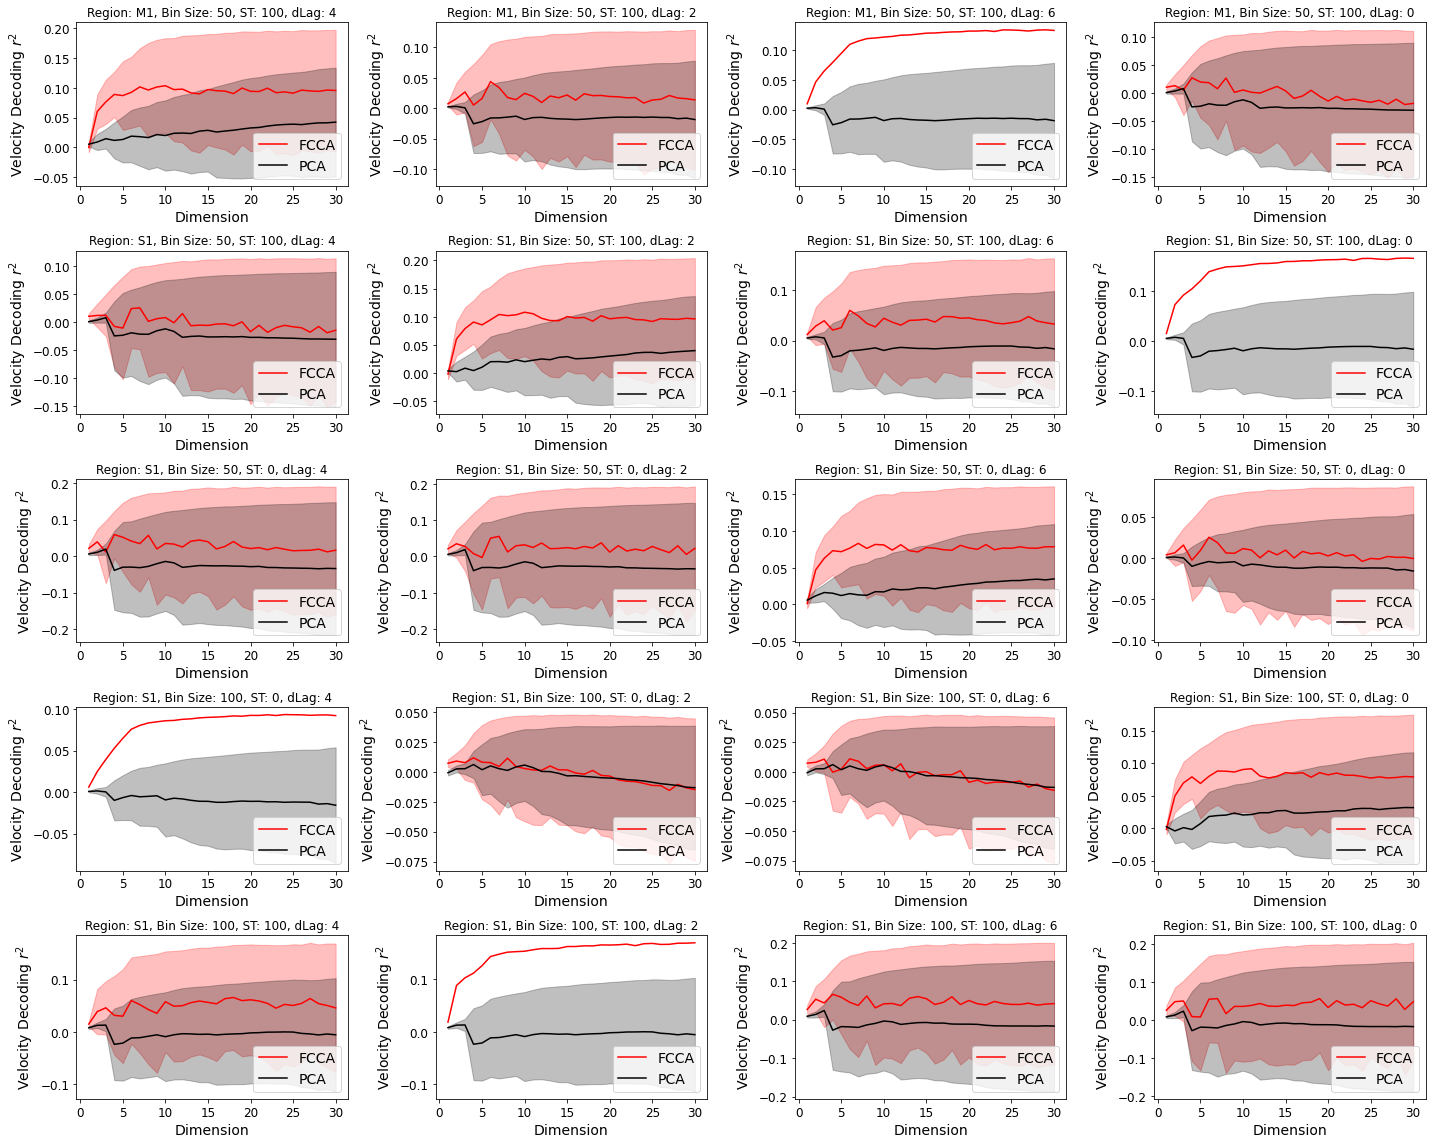

In [6]:
fig, axx = plt.subplots(5, 4, figsize=(20, 16))

# Average across folds and plot
# REINSERT OLS(5) IN HERE IF NEEDED

colors = ['black', 'red', '#781820', '#5563fa']
dim_vals =dims

# # DCA averaged over folds
# dca_r2 = np.nanmean(r2[:, :, 1, :, 1], axis=2)
# # KCA averaged over folds
# kca_r2 = np.nanmean(r2[:, :, 2, :, 1], axis=2)

# FCCA averaged over folds
fca_r2 = np.nanmean(r2fc[..., 1], axis=3)
# PCA
pca_r2 = np.nanmean(r2pca[..., 1], axis=3)

# ax.fill_between(dim_vals, np.nanmean(dca_r2, axis=0) + np.std(dca_r2, axis=0)/np.sqrt(28),
#                 np.nanmean(dca_r2, axis=0) - np.std(dca_r2, axis=0)/np.sqrt(28), color=colors[0], alpha=0.25)
# ax.plot(dim_vals, np.nanmean(dca_r2, axis=0), color=colors[0])
# ax.fill_between(dim_vals, np.nanmean(kca_r2, axis=0) + np.std(kca_r2, axis=0)/np.sqrt(28),
#                 np.nanmean(kca_r2, axis=0) - np.std(kca_r2, axis=0)/np.sqrt(28), color=colors[1], alpha=0.25)
# ax.plot(dim_vals, np.nanmean(kca_r2, axis=0), color=colors[1])

arg_combos = list(itertools.product(loader_args, decoders))

for i in range(20):
    ax = axx[np.unravel_index(i, (5, 4))]
    ax.fill_between(dim_vals, np.nanmean(fca_r2[:, i, ...], axis=0) + np.std(fca_r2[:, i, ...], axis=0)/np.sqrt(fca_r2.shape[0]),
                    np.nanmean(fca_r2[:, i, ...], axis=0) - np.std(fca_r2[:, i, ...], axis=0)/np.sqrt(fca_r2.shape[0]), color=colors[1], alpha=0.25)
    ax.plot(dim_vals, np.nanmean(fca_r2[:, i, ...], axis=0), color=colors[1])

    ax.fill_between(dim_vals, np.nanmean(pca_r2[:, i, ...], axis=0) + np.std(pca_r2[:, i, ...], axis=0)/np.sqrt(fca_r2.shape[0]),
                    np.nanmean(pca_r2[:, i, ...], axis=0) - np.std(pca_r2[:, i, ...], axis=0)/np.sqrt(fca_r2.shape[0]), color=colors[0], alpha=0.25)
    ax.plot(dim_vals, np.nanmean(pca_r2[:, i, ...], axis=0), color=colors[0])

    ax.set_xlabel('Dimension', fontsize=14)
    ax.set_ylabel('Velocity Decoding ' + r'$r^2$', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    loader_arg, decoder_arg = arg_combos[i]
    ax.legend(['FCCA', 'PCA'], loc='lower right', fontsize=14)
    ax.set_title('Region: %s, Bin Size: %d, ST: %d, dLag: %d' % (loader_arg['region'], loader_arg['bin_width'], loader_arg['spike_threshold'], decoder_arg['trainlag']))

fig.tight_layout()
# fig.savefig('%s/indy_vel_decoding.pdf' % figpath, bbox_inches='tight', pad_inches=0)


In [ ]:
# 

In [ ]:
# S1 has some predictive power at very long lags. Might try shorter bin sizes and negative lags

### Subspace Angles

In [43]:
# Which decoder args yields the most LQGCA completed fits?
apply_df_filters(sabes_df, dimreduc_method='LQGCA', dim=dim, decoder_args=decoders[3]).shape

(240, 18)

In [45]:
loader_args

[{'bin_width': 50,
  'filter_fn': 'none',
  'filter_kwargs': {},
  'boxcox': 0.5,
  'spike_threshold': 100,
  'region': 'M1'},
 {'bin_width': 50,
  'filter_fn': 'none',
  'filter_kwargs': {},
  'boxcox': 0.5,
  'spike_threshold': 100,
  'region': 'S1'},
 {'bin_width': 50,
  'filter_fn': 'none',
  'filter_kwargs': {},
  'boxcox': 0.5,
  'spike_threshold': 0,
  'region': 'S1'},
 {'bin_width': 100,
  'filter_fn': 'none',
  'filter_kwargs': {},
  'boxcox': 0.5,
  'spike_threshold': 0,
  'region': 'S1'},
 {'bin_width': 100,
  'filter_fn': 'none',
  'filter_kwargs': {},
  'boxcox': 0.5,
  'spike_threshold': 100,
  'region': 'S1'}]

In [53]:
# Which loader arg yields the most LQGCA completed fits? For M1 there is just one option. For S1 we have a few
apply_df_filters(sabes_df, dimreduc_method='LQGCA', dim=dim, loader_args=loader_args[3]).shape

(200, 18)

In [54]:
loader_args[1]

{'bin_width': 50,
 'filter_fn': 'none',
 'filter_kwargs': {},
 'boxcox': 0.5,
 'spike_threshold': 100,
 'region': 'S1'}

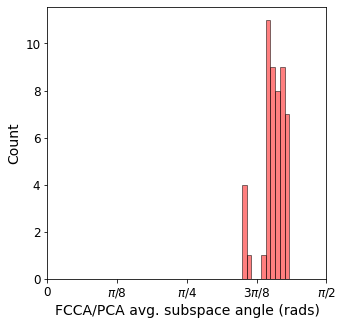

In [55]:
dim = 6
data_files = np.unique(sabes_df['data_file'].values)
folds = np.arange(5)
ss_angles = np.zeros((len(data_files), 5, dim))
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCA']

# Pick one
decoder_arg = sabes_df.iloc[0]['decoder_args']
# This one seems to be complete - the details also matter here, but they match the default sabes one
loader_arg = loader_args[0]
df = apply_df_filters(sabes_df, decoder_args=decoder_arg, loader_args=loader_arg)

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):

        dfpca = apply_df_filters(df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
ax.set_xlim([0, np.pi/2])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/loco/M1_ssangles.pdf', bbox_inches='tight')

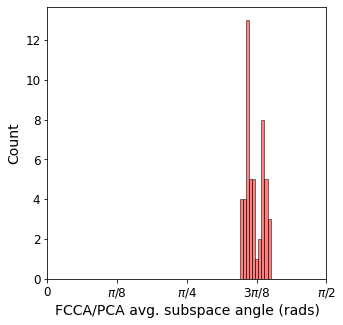

In [56]:
dim = 6
data_files = np.unique(sabes_df['data_file'].values)
folds = np.arange(5)
ss_angles = np.zeros((len(data_files), 5, dim))
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCA']

# Pick one
decoder_arg = sabes_df.iloc[0]['decoder_args']
# This one seems to be complete - the details also matter here, but they match the default sabes one
loader_arg = loader_args[1]
df = apply_df_filters(sabes_df, decoder_args=decoder_arg, loader_args=loader_arg)

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):

        dfpca = apply_df_filters(df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
ax.set_xlim([0, np.pi/2])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/loco/S1_ssangles.pdf', bbox_inches='tight')

# Single Unit Scatter and Histogram

In [57]:
# Reduce to a single loader and decoder arg
m1df = apply_df_filters(sabes_df, decoder_args=decoder_arg, loader_args=loader_args[0])
s1df = apply_df_filters(sabes_df, decoder_args=decoder_arg, loader_args=loader_args[1])

10it [00:00, 93.04it/s]
10it [00:00, 259.19it/s]


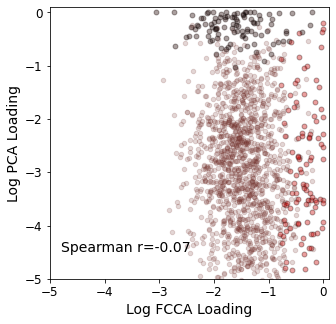

In [58]:
DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(m1df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(m1df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

M1_loadings_df = pd.DataFrame(loadings_l)

# For each data file, find the top 5 neurons that are high in one method but low in all others
top_neurons_l = []
n = 10
for i, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(M1_loadings_df, data_file=data_file)
    # DCA_ordering = np.argsort(df_['DCA_loadings'].values)
    # KCA_ordering = np.argsort(df_['KCA_loadings'].values)
    FCCA_ordering = np.argsort(df_['FCCA_loadings'].values)
    PCA_ordering = np.argsort(df_['PCA_loadings'].values)
    
    rank_diffs = np.zeros((FCCA_ordering.size, 1))
    for j in range(df_.shape[0]):
        rank_diffs[j, 0] = list(FCCA_ordering).index(j) - list(PCA_ordering).index(j)

    # Find the top 5 neurons according to all pairwise high/low orderings
    top_neurons = np.zeros((2, n)).astype(int)

    # DCA_top = set([])
    # KCA_top = set([])
    FCCA_top = []
    PCA_top = []

    idx = 0
    while not np.all([len(x) >= n for x in [FCCA_top, PCA_top]]):
        idx += 1
        # Take neurons from the top ordering of each method. Disregard neurons that 
        # show up in all methods
        # top_DCA = DCA_ordering[-idx]
        top_FCCA = FCCA_ordering[-idx]
        top_PCA = PCA_ordering[-idx]

        if top_FCCA != top_PCA:
            if top_FCCA not in PCA_top:
                FCCA_top.append(top_FCCA)
            if top_PCA not in FCCA_top:
                PCA_top.append(top_PCA)
        else:
            continue

    top_neurons[0, :] = FCCA_top[0:n]
    top_neurons[1, :] = PCA_top[0:n] 

    top_neurons_l.append({'data_file':data_file, 'rank_diffs':rank_diffs, 'top_neurons': top_neurons}) 

# Re-scatter with the top neurons highlighted
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#df_ = apply_df_filters(loadings_df, dim=6)
df_ = M1_loadings_df

x1 = df_['FCCA_loadings'].values
x2 = df_['PCA_loadings'].values

#x1idxs = np.arange(x1.size)[x1 > np.quantile(x1, 0.75)]
q1_pca = np.quantile(x2, 0.75)
q1_fca = np.quantile(x1, 0.75)

# Plot vertical lines at the PCA quantile
#ax.hlines(np.log10(q1_pca), -5, 0, color='k')
#ax.vlines(np.log10(q1_fca), -5, 0, color='k')

#x1 = x1[x1idxs]
#x2 = x2[x1idxs]
#x1 = x1[x1 > np.quantile(x1, 0.05)]
#x2 = x2[x2 > np.quantile(x2, 0.05)]

ax.scatter(np.log10(x1), np.log10(x2), alpha=0.2, color='#753530', s=20)

for i in range(len(top_neurons_l)):
    idxs1 = top_neurons_l[i]['top_neurons'][0, :]
    idxs2 = top_neurons_l[i]['top_neurons'][1, :]
    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs1[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='r', alpha=0.25, edgecolors='k', s=25)

    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs2[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='k', alpha=0.25, edgecolors='k', s=25)

ax.set_xlim([-5, 0.1])
ax.set_ylim([-5, 0.1])
ax.set_xlabel('Log FCCA Loading', fontsize=14)
ax.set_ylabel('Log PCA Loading', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Annotate with the spearman-r
r = scipy.stats.spearmanr(x1, x2)[0]

# What is the spearman correlation in the intersection of the upper quartiles?
idxs1 = np.argwhere(x1 > q1_fca)[:, 0]
idxs2 = np.argwhere(x2 > q1_pca)[:, 0]
intersct = np.array(list(set(idxs1).intersection(set(idxs2))))

r2 = scipy.stats.spearmanr(x1[intersct], x2[intersct])[0]
ax.annotate('Spearman r=%.2f' % r, (-4.8, -4.5), fontsize=14)
# ax.annotate('Upper-quartile r=%.2f' % r2, (-4.8, -0.5), fontsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco/M1_scatter.pdf', bbox_inches='tight', pad_inches=0)

10it [00:00, 91.35it/s]
10it [00:00, 247.19it/s]


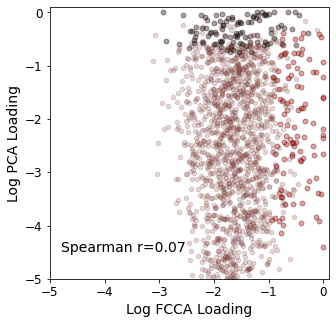

In [59]:
DIM = 6

# Try the raw leverage scores instead
loadings_l = []
data_files = np.unique(s1df['data_file'].values)
for i, data_file in tqdm(enumerate(data_files)):
    loadings = []
    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            df_ = apply_df_filters(s1df, data_file=data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    for j in range(loadings[0].size):
        d_ = {}
        d_['data_file'] = data_file
        d_['FCCA_loadings'] = loadings[0][j]
        d_['PCA_loadings'] = loadings[1][j]
        # d_['DCA_loadings'] = loadings[2][j]
        d_['nidx'] = j
        loadings_l.append(d_)                

S1_loadings_df = pd.DataFrame(loadings_l)

# For each data file, find the top 5 neurons that are high in one method but low in all others
top_neurons_l = []
n = 10
for i, data_file in tqdm(enumerate(data_files)):
    df_ = apply_df_filters(S1_loadings_df, data_file=data_file)
    # DCA_ordering = np.argsort(df_['DCA_loadings'].values)
    # KCA_ordering = np.argsort(df_['KCA_loadings'].values)
    FCCA_ordering = np.argsort(df_['FCCA_loadings'].values)
    PCA_ordering = np.argsort(df_['PCA_loadings'].values)
    
    rank_diffs = np.zeros((FCCA_ordering.size, 1))
    for j in range(df_.shape[0]):
        rank_diffs[j, 0] = list(FCCA_ordering).index(j) - list(PCA_ordering).index(j)

    # Find the top 5 neurons according to all pairwise high/low orderings
    top_neurons = np.zeros((2, n)).astype(int)

    # DCA_top = set([])
    # KCA_top = set([])
    FCCA_top = []
    PCA_top = []

    idx = 0
    while not np.all([len(x) >= n for x in [FCCA_top, PCA_top]]):
        idx += 1
        # Take neurons from the top ordering of each method. Disregard neurons that 
        # show up in all methods
        # top_DCA = DCA_ordering[-idx]
        top_FCCA = FCCA_ordering[-idx]
        top_PCA = PCA_ordering[-idx]

        if top_FCCA != top_PCA:
            if top_FCCA not in PCA_top:
                FCCA_top.append(top_FCCA)
            if top_PCA not in FCCA_top:
                PCA_top.append(top_PCA)
        else:
            continue

    top_neurons[0, :] = FCCA_top[0:n]
    top_neurons[1, :] = PCA_top[0:n] 

    top_neurons_l.append({'data_file':data_file, 'rank_diffs':rank_diffs, 'top_neurons': top_neurons}) 

# Re-scatter with the top neurons highlighted
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

#df_ = apply_df_filters(loadings_df, dim=6)
df_ = S1_loadings_df

x1 = df_['FCCA_loadings'].values
x2 = df_['PCA_loadings'].values

#x1idxs = np.arange(x1.size)[x1 > np.quantile(x1, 0.75)]
q1_pca = np.quantile(x2, 0.75)
q1_fca = np.quantile(x1, 0.75)

# Plot vertical lines at the PCA quantile
#ax.hlines(np.log10(q1_pca), -5, 0, color='k')
#ax.vlines(np.log10(q1_fca), -5, 0, color='k')

#x1 = x1[x1idxs]
#x2 = x2[x1idxs]
#x1 = x1[x1 > np.quantile(x1, 0.05)]
#x2 = x2[x2 > np.quantile(x2, 0.05)]

ax.scatter(np.log10(x1), np.log10(x2), alpha=0.2, color='#753530', s=20)

for i in range(len(top_neurons_l)):
    idxs1 = top_neurons_l[i]['top_neurons'][0, :]
    idxs2 = top_neurons_l[i]['top_neurons'][1, :]
    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs1[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='r', alpha=0.25, edgecolors='k', s=25)

    x = []
    y = []
    for j in range(len(idxs1)):
        d = apply_df_filters(df_, data_file=top_neurons_l[i]['data_file'], nidx=idxs2[j])
        assert(d.shape[0] == 1)
        x.append(d.iloc[0]['FCCA_loadings'])
        y.append(d.iloc[0]['PCA_loadings'])
    ax.scatter(np.log10(x), np.log10(y), color='k', alpha=0.25, edgecolors='k', s=25)

ax.set_xlim([-5, 0.1])
ax.set_ylim([-5, 0.1])
ax.set_xlabel('Log FCCA Loading', fontsize=14)
ax.set_ylabel('Log PCA Loading', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Annotate with the spearman-r
r = scipy.stats.spearmanr(x1, x2)[0]

# What is the spearman correlation in the intersection of the upper quartiles?
idxs1 = np.argwhere(x1 > q1_fca)[:, 0]
idxs2 = np.argwhere(x2 > q1_pca)[:, 0]
intersct = np.array(list(set(idxs1).intersection(set(idxs2))))

r2 = scipy.stats.spearmanr(x1[intersct], x2[intersct])[0]
ax.annotate('Spearman r=%.2f' % r, (-4.8, -4.5), fontsize=14)
# ax.annotate('Upper-quartile r=%.2f' % r2, (-4.8, -0.5), fontsize=14)
fig.savefig('/home/akumar/nse/neural_control/figs/loco/S1_scatter.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Do the PSTH and boxplot analysis from the analysis script

### Single unit calculations

In [60]:
from dca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from decoders import lr_encoder, lr_decoder
from utils import calc_cascaded_loadings
import torch

In [19]:
M1_su_l = []
m1df = apply_df_filters(sabes_df, decoder_args=decoders[0], loader_args=loader_args[0])

#data_path = '/mnt/sdb1/nc_data/sabes'
data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(m1df['data_file'].values)

loader_arg = loader_args[0]
decoder_params = decoders[0]

for i, data_file in tqdm(enumerate(data_files)):    
    dat = load_sabes('%s/%s' % (data_path, data_file), bin_width=loader_arg["bin_width"],
                        filter_fn=loader_arg['filter_fn'], filter_kwargs=loader_arg['filter_kwargs'],
                        boxcox=loader_arg['boxcox'], spike_threshold=loader_arg['spike_threshold'])

    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']

    kfold = KFold(n_splits=5, shuffle=False)

    # Average results across folds
    decoding_weights = []
    encoding_weights = []
    su_decoding_weights = []
    su_encoding_weights = []
    su_r2_pos = []
    su_r2_vel = []
    su_r2_enc = []

    # Single unit statistics
    su_var = np.zeros((5, X.shape[-1]))
    su_mmse = np.zeros((5, X.shape[-1]))
    su_pi = np.zeros((5, X.shape[-1]))
    su_fcca = np.zeros((5, X.shape[-1]))

    # decoding/encoding weights after projection
    dims = np.arange(2, 11)
    proj_dw_pos = np.zeros((5, 4, dims.size, X.shape[-1]))
    proj_dw_vel = np.zeros((5, 4, dims.size, X.shape[-1]))
    proj_ew = np.zeros((5, 4, dims.size, X.shape[-1]))

    for fold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(X)):

        r = {}

        ztrain = Z[train_idxs, :]
        ztest = Z[test_idxs, :]

        # Population level decoding/encoding - use the coefficient in the linear fit
        # Record both the weights in the coefficient but also the loadings onto the SVD

        xtrain = X[train_idxs, :]
        xtest = X[test_idxs, :]

        ccm = calc_cross_cov_mats_from_data(xtrain, T=10)
        ccm = torch.tensor(ccm)

        _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

        decoding_weights.append(decodingregressor.coef_)
        encoding_weights.append(encodingregressor.coef_)                
        
        r2_pos_decoding, r2_vel_decoding, r2_encoding = [], [], []
        
        su_dw = []
        su_ew = []            
        sur2pos = []
        sur2vel = []
        sur2enc = []
        for neu_idx in range(X.shape[-1]):           #Fit all neurons one by one
            
            xtrain = X[train_idxs, neu_idx][:, np.newaxis]
            xtest = X[test_idxs, neu_idx][:, np.newaxis]

            # Decoding
            r2_pos, r2_vel, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_pos_decoding.append(r2_pos)
            r2_vel_decoding.append(r2_vel)
            su_dw.append(dr.coef_)
            sur2pos.append(r2_pos)
            sur2vel.append(r2_vel)

            # Encoding
            r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_encoding.append(r2_encoding_)
            su_ew.append(er.coef_)        
            sur2enc.append(r2_encoding_)


        su_decoding_weights.append(np.array(su_dw))
        su_encoding_weights.append(np.array(su_ew))
        
        su_r2_pos.append(np.array(sur2pos))
        su_r2_vel.append(np.array(sur2vel))
        su_r2_enc.append(np.array(sur2enc))
        
        #lqg_loss = build_lqg_loss(ccm, 1, ortho_lambda=0., project_mmse=False, loss_type='trace')

        for neu_idx in range(X.shape[-1]):

            xtrain = X[train_idxs, neu_idx][:, np.newaxis]
            xtest = X[test_idxs, neu_idx][:, np.newaxis]

            su_var[fold_idx, neu_idx] = np.var(xtrain)
            proj = np.zeros((ccm.shape[-1], 1))
            proj[neu_idx] = 1
            proj = torch.tensor(proj)
            #su_mmse[fold_idx, neu_idx] = calc_mmse_from_cross_cov_mats(ccm[0:4, ...], proj=proj).numpy()
            su_pi[fold_idx, neu_idx] = calc_pi_from_cross_cov_mats(torch.unsqueeze(torch.unsqueeze(ccm[0:9, neu_idx ,neu_idx], 1), 2))
            #su_fcca[fold_idx, neu_idx] = lqg_loss(proj).numpy()            

        # Calculate decoding weights based on projection of the data first

        xtrain = X[train_idxs, :]
        xtest = X[test_idxs, :]

        for dr_idx, dimreduc_method in enumerate(['LQGCA', 'PCA']):
            for didx, d in enumerate(dims):
                df_ = apply_df_filters(m1df, data_file=data_file, fold_idx=fold_idx, dim=d, dimreduc_method=dimreduc_method)
                if dimreduc_method == 'LQGCA':
                    V = df_.iloc[0]['coef']
                if dimreduc_method == 'PCA':
                    V = V[:, 0:d]
                try:
                    xtrain_proj = xtrain @ V 
                    xtest_proj = xtest @ V
                except:
                    pdb.set_trace()

                _, _, _, decodingregressor = lr_decoder(xtest_proj, xtrain_proj, ztest, ztrain, **decoder_params)
                _, encodingregressor = lr_encoder(xtest_proj, xtrain_proj, ztest, ztrain, **decoder_params)
                proj_dw_pos[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, decodingregressor.coef_[0:2, :].T, d2= decoder_params['decoding_window'])
                proj_dw_vel[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, decodingregressor.coef_[2:4, :].T, d2= decoder_params['decoding_window'])
                proj_ew[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, encodingregressor.coef_)

    # Average results across folds
    decoding_weights = np.mean(np.array(decoding_weights), axis=0)
    encoding_weights = np.mean(np.array(encoding_weights), axis=0)
    su_decoding_weights = np.mean(np.array(su_decoding_weights), axis=0)
    su_encoding_weights = np.mean(np.array(su_encoding_weights), axis=0)

    su_r2_pos = np.mean(np.array(su_r2_pos), axis=0)
    su_r2_vel = np.mean(np.array(su_r2_vel), axis=0)
    su_r2_enc = np.mean(np.array(su_r2_enc), axis=0)

    su_var = np.mean(su_var, axis=0)
    su_mmse = np.mean(su_mmse, axis=0)
    su_pi = np.mean(su_pi, axis=0)
    su_fcca = np.mean(su_fcca, axis=0)

    proj_dw_pos = np.mean(proj_dw_pos, axis=0)
    proj_dw_vel = np.mean(proj_dw_vel, axis=0)
    proj_ew = np.mean(proj_ew, axis=0)

    result = {}
    for variable in ('data_file', 'decoding_weights', 'encoding_weights', 'su_decoding_weights', 'su_encoding_weights', 'su_r2_pos',
                        'su_r2_vel', 'su_r2_enc', 'su_var', 'su_mmse', 'su_pi', 'su_fcca', 'proj_dw_pos', 'proj_dw_vel', 'proj_ew', 'decoder_params'):
        result[variable] = eval(variable)

    M1_su_l.append(result)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:15<00:00, 15.17s/it]
1it [00:37, 37.20s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.21s/it]
2it [01:26, 44.39s/it]

Processing spikes


100%|██████████| 1/1 [00:26<00:00, 26.50s/it]
3it [02:33, 54.55s/it]

Processing spikes


100%|██████████| 1/1 [00:09<00:00,  9.39s/it]
4it [02:56, 42.19s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.66s/it]
5it [03:52, 47.18s/it]

Processing spikes


100%|██████████| 1/1 [00:15<00:00, 15.32s/it]
6it [04:31, 44.25s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.82s/it]
7it [05:18, 45.17s/it]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.80s/it]
8it [06:00, 44.30s/it]

Processing spikes


100%|██████████| 1/1 [00:09<00:00,  9.60s/it]
9it [06:31, 40.26s/it]

Processing spikes


100%|██████████| 1/1 [00:18<00:00, 18.98s/it]
10it [07:28, 44.85s/it]


In [63]:
def get_scalar(df_, stat, neu_idx):

    if stat == 'decoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        # Restrict to velocity decoding
        c = calc_loadings(df_.iloc[0]['decoding_weights'][2:4].T, d=decoding_win)[neu_idx]
    elif stat == 'encoding_weights':
        decoding_win = df_.iloc[0]['decoder_params']['decoding_window']
        c =  calc_loadings(df_.iloc[0]['encoding_weights'], d=decoding_win)[neu_idx]        
    elif stat in ['su_r2_pos', 'su_r2_vel', 'su_r2_enc', 'su_var', 'su_mmse', 'su_pi', 'su_fcca']:
        c = df_.iloc[0][stat][neu_idx]  
    elif stat == 'orientation_tuning':
        c = np.zeros(8)
        for j in range(8):
            c[j] = df_.loc[df_['bin_idx'] == j].iloc[0]['tuning_r2'][j, 2, neu_idx]
        c = np.mean(c)
        # c = odf_.iloc[0]

    return c

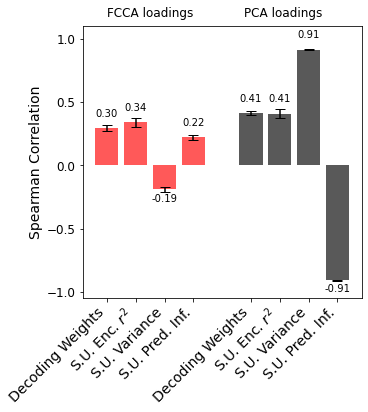

In [65]:
# Histogram
sabes_su_df = pd.DataFrame(M1_su_l)

# Dimensionality selection
itrim_df = M1_loadings_df
data_files = np.unique(itrim_df['data_file'].values)

# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['decoding_weights', 'su_r2_enc', 'su_var', 'su_pi']

carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):                    # Find the correlation between 
        for k, stat in enumerate(stats):
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            carray_[j, k] = get_scalar(df_, stat, nidx)
    carray.append(carray_)

su_r = np.zeros((len(carray), 2, carray[0].shape[1]))
keys = ['FCCA_loadings', 'PCA_loadings']
for i in range(len(carray)):
    for j in range(2):
        for k in range(carray[0].shape[1]):
            df = apply_df_filters(itrim_df, data_file=data_files[i])

            # Enforce intersection with the upper quartile of each respective statistic
            # Method loadings
            x1 = df[keys[j]].values
            q1 = np.quantile(x1, 0.75)
            # # Single unit statistic
            x2 = carray[i][:, k]
            q2 = np.quantile(x2, 0.75)

            idxs1 = np.argwhere(x1 > q1)[:, 0]
            idxs2 = np.argwhere(x2 > q2)[:, 0]
            #intersct = np.array(list(set(idxs1).intersection(set(idxs2))))
            #intersct = idxs1
            intersct = np.arange(x1.size)
            if len(intersct) > 0:
                su_r[i, j, k] = scipy.stats.spearmanr(x1[intersct], x2[intersct])[0]
            else:
                su_r[i, j, k] = 0

fig, ax = plt.subplots(figsize=(5, 5),)

bars = ax.bar([0, 1, 2, 3, 5, 6, 7, 8],
            np.mean(su_r[:, -2:, :], axis=0).ravel(),
            color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65,
            yerr=np.std(su_r[:, -2:, :], axis=0).ravel()/np.sqrt(28), capsize=5)


# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.075), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)
    else:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.11), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)

ax.set_ylim([-1.05, 1.1])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8])

ax.set_xticklabels(['Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.',
                    'Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.'], rotation=45, fontsize=14, ha='right')

ax.tick_params(axis='y', labelsize=12)

ax.text(0, 1.15, 'FCCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(-0.5, -0.3), xytext=(3.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.text(4.75, 1.15, 'PCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(4.5, -0.3), xytext=(8.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=14)
ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
fig.savefig('/home/akumar/nse/neural_control/figs/loco/M1_hist.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
# Do the same thing for S1
S1_su_l = []

loader_arg = loader_args[1]
decoder_params = decoders[0]
s1df = apply_df_filters(sabes_df, decoder_args=decoder_params, loader_args=loader_arg)

#data_path = '/mnt/sdb1/nc_data/sabes'
data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(s1df['data_file'].values)

for i, data_file in tqdm(enumerate(data_files)):    
    dat = load_sabes('%s/%s' % (data_path, data_file), bin_width=loader_arg["bin_width"],
                        filter_fn=loader_arg['filter_fn'], filter_kwargs=loader_arg['filter_kwargs'],
                        boxcox=loader_arg['boxcox'], spike_threshold=loader_arg['spike_threshold'], region=loader_arg['region'])

    X = np.squeeze(dat['spike_rates'])
    Z = dat['behavior']

    kfold = KFold(n_splits=5, shuffle=False)

    # Average results across folds
    decoding_weights = []
    encoding_weights = []
    su_decoding_weights = []
    su_encoding_weights = []
    su_r2_pos = []
    su_r2_vel = []
    su_r2_enc = []

    # Single unit statistics
    su_var = np.zeros((5, X.shape[-1]))
    su_mmse = np.zeros((5, X.shape[-1]))
    su_pi = np.zeros((5, X.shape[-1]))
    su_fcca = np.zeros((5, X.shape[-1]))

    # decoding/encoding weights after projection
    dims = np.arange(2, 11)
    proj_dw_pos = np.zeros((5, 4, dims.size, X.shape[-1]))
    proj_dw_vel = np.zeros((5, 4, dims.size, X.shape[-1]))
    proj_ew = np.zeros((5, 4, dims.size, X.shape[-1]))

    for fold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(X)):

        r = {}

        ztrain = Z[train_idxs, :]
        ztest = Z[test_idxs, :]

        # Population level decoding/encoding - use the coefficient in the linear fit
        # Record both the weights in the coefficient but also the loadings onto the SVD

        xtrain = X[train_idxs, :]
        xtest = X[test_idxs, :]

        ccm = calc_cross_cov_mats_from_data(xtrain, T=10)
        ccm = torch.tensor(ccm)

        _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

        decoding_weights.append(decodingregressor.coef_)
        encoding_weights.append(encodingregressor.coef_)                
        
        r2_pos_decoding, r2_vel_decoding, r2_encoding = [], [], []
        
        su_dw = []
        su_ew = []            
        sur2pos = []
        sur2vel = []
        sur2enc = []
        for neu_idx in range(X.shape[-1]):           #Fit all neurons one by one
            
            xtrain = X[train_idxs, neu_idx][:, np.newaxis]
            xtest = X[test_idxs, neu_idx][:, np.newaxis]

            # Decoding
            r2_pos, r2_vel, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_pos_decoding.append(r2_pos)
            r2_vel_decoding.append(r2_vel)
            su_dw.append(dr.coef_)
            sur2pos.append(r2_pos)
            sur2vel.append(r2_vel)

            # Encoding
            r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_encoding.append(r2_encoding_)
            su_ew.append(er.coef_)        
            sur2enc.append(r2_encoding_)


        su_decoding_weights.append(np.array(su_dw))
        su_encoding_weights.append(np.array(su_ew))
        
        su_r2_pos.append(np.array(sur2pos))
        su_r2_vel.append(np.array(sur2vel))
        su_r2_enc.append(np.array(sur2enc))
        
        #lqg_loss = build_lqg_loss(ccm, 1, ortho_lambda=0., project_mmse=False, loss_type='trace')

        for neu_idx in range(X.shape[-1]):

            xtrain = X[train_idxs, neu_idx][:, np.newaxis]
            xtest = X[test_idxs, neu_idx][:, np.newaxis]

            su_var[fold_idx, neu_idx] = np.var(xtrain)
            proj = np.zeros((ccm.shape[-1], 1))
            proj[neu_idx] = 1
            proj = torch.tensor(proj)
            #su_mmse[fold_idx, neu_idx] = calc_mmse_from_cross_cov_mats(ccm[0:4, ...], proj=proj).numpy()
            su_pi[fold_idx, neu_idx] = calc_pi_from_cross_cov_mats(torch.unsqueeze(torch.unsqueeze(ccm[0:9, neu_idx ,neu_idx], 1), 2))
            #su_fcca[fold_idx, neu_idx] = lqg_loss(proj).numpy()            

        # Calculate decoding weights based on projection of the data first

        xtrain = X[train_idxs, :]
        xtest = X[test_idxs, :]

        for dr_idx, dimreduc_method in enumerate(['LQGCA', 'PCA']):
            for didx, d in enumerate(dims):
                df_ = apply_df_filters(s1df, data_file=data_file, fold_idx=fold_idx, dim=d, dimreduc_method=dimreduc_method)
                if dimreduc_method == 'LQGCA':
                    V = df_.iloc[0]['coef']
                if dimreduc_method == 'PCA':
                    V = V[:, 0:d]
                try:
                    xtrain_proj = xtrain @ V 
                    xtest_proj = xtest @ V
                except:
                    pdb.set_trace()

                _, _, _, decodingregressor = lr_decoder(xtest_proj, xtrain_proj, ztest, ztrain, **decoder_params)
                _, encodingregressor = lr_encoder(xtest_proj, xtrain_proj, ztest, ztrain, **decoder_params)
                proj_dw_pos[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, decodingregressor.coef_[0:2, :].T, d2= decoder_params['decoding_window'])
                proj_dw_vel[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, decodingregressor.coef_[2:4, :].T, d2= decoder_params['decoding_window'])
                proj_ew[fold_idx, dr_idx, didx, :] = calc_cascaded_loadings(V, encodingregressor.coef_)

    # Average results across folds
    decoding_weights = np.mean(np.array(decoding_weights), axis=0)
    encoding_weights = np.mean(np.array(encoding_weights), axis=0)
    su_decoding_weights = np.mean(np.array(su_decoding_weights), axis=0)
    su_encoding_weights = np.mean(np.array(su_encoding_weights), axis=0)

    su_r2_pos = np.mean(np.array(su_r2_pos), axis=0)
    su_r2_vel = np.mean(np.array(su_r2_vel), axis=0)
    su_r2_enc = np.mean(np.array(su_r2_enc), axis=0)

    su_var = np.mean(su_var, axis=0)
    su_mmse = np.mean(su_mmse, axis=0)
    su_pi = np.mean(su_pi, axis=0)
    su_fcca = np.mean(su_fcca, axis=0)

    proj_dw_pos = np.mean(proj_dw_pos, axis=0)
    proj_dw_vel = np.mean(proj_dw_vel, axis=0)
    proj_ew = np.mean(proj_ew, axis=0)

    result = {}
    for variable in ('data_file', 'decoding_weights', 'encoding_weights', 'su_decoding_weights', 'su_encoding_weights', 'su_r2_pos',
                        'su_r2_vel', 'su_r2_enc', 'su_var', 'su_mmse', 'su_pi', 'su_fcca', 'proj_dw_pos', 'proj_dw_vel', 'proj_ew', 'decoder_params'):
        result[variable] = eval(variable)

    S1_su_l.append(result)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.58s/it]
1it [00:39, 39.07s/it]

Processing spikes


100%|██████████| 1/1 [00:20<00:00, 20.22s/it]
2it [01:34, 48.48s/it]

Processing spikes


100%|██████████| 1/1 [00:27<00:00, 27.06s/it]
3it [02:44, 58.41s/it]

Processing spikes


100%|██████████| 1/1 [00:09<00:00,  9.31s/it]
4it [03:10, 45.81s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.69s/it]
5it [04:09, 50.34s/it]

Processing spikes


100%|██████████| 1/1 [00:15<00:00, 15.35s/it]
6it [04:53, 48.19s/it]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.84s/it]
7it [05:42, 48.51s/it]

Processing spikes


100%|██████████| 1/1 [00:14<00:00, 14.89s/it]
8it [06:27, 47.43s/it]

Processing spikes


100%|██████████| 1/1 [00:09<00:00,  9.76s/it]
9it [06:54, 41.02s/it]

Processing spikes


100%|██████████| 1/1 [00:19<00:00, 19.24s/it]
10it [07:47, 46.74s/it]


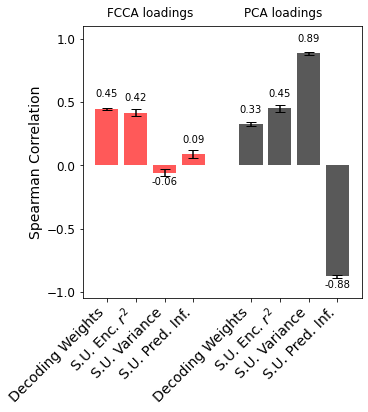

In [66]:
# Histogram
sabes_su_df = pd.DataFrame(S1_su_l)

# Dimensionality selection
itrim_df = S1_loadings_df
data_files = np.unique(itrim_df['data_file'].values)

# Collect the desired single unit statistics into an array with the same ordering as those present in the loadings df
stats = ['decoding_weights', 'su_r2_enc', 'su_var', 'su_pi']

carray = []
for i, data_file in enumerate(data_files):
    df = apply_df_filters(itrim_df, data_file=data_file)
    carray_ = np.zeros((df.shape[0], len(stats)))
    for j in range(df.shape[0]):                    # Find the correlation between 
        for k, stat in enumerate(stats):
            # Grab the unique identifiers needed
            nidx = df.iloc[j]['nidx']
            if stat == 'orientation_tuning':
                df_ = apply_df_filters(odf, file=data_file, tau=4)
            else:
                df_ = apply_df_filters(sabes_su_df, data_file=data_file)
            try:
                carray_[j, k] = get_scalar(df_, stat, nidx)
            except:
                pdb.set_trace()
    carray.append(carray_)

su_r = np.zeros((len(carray), 2, carray[0].shape[1]))
keys = ['FCCA_loadings', 'PCA_loadings']
for i in range(len(carray)):
    for j in range(2):
        for k in range(carray[0].shape[1]):
            df = apply_df_filters(itrim_df, data_file=data_files[i])

            # Enforce intersection with the upper quartile of each respective statistic
            # Method loadings
            x1 = df[keys[j]].values
            q1 = np.quantile(x1, 0.75)
            # # Single unit statistic
            x2 = carray[i][:, k]
            q2 = np.quantile(x2, 0.75)

            idxs1 = np.argwhere(x1 > q1)[:, 0]
            idxs2 = np.argwhere(x2 > q2)[:, 0]
            #intersct = np.array(list(set(idxs1).intersection(set(idxs2))))
            #intersct = idxs1
            intersct = np.arange(x1.size)
            if len(intersct) > 0:
                su_r[i, j, k] = scipy.stats.spearmanr(x1[intersct], x2[intersct])[0]
            else:
                su_r[i, j, k] = 0

fig, ax = plt.subplots(figsize=(5, 5),)

bars = ax.bar([0, 1, 2, 3, 5, 6, 7, 8],
            np.mean(su_r[:, -2:, :], axis=0).ravel(),
            color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65,
            yerr=np.std(su_r[:, -2:, :], axis=0).ravel()/np.sqrt(28), capsize=5)


# Place numerical values above the bars
for rect in bars: 
    if rect.get_height() > 0:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.075), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)
                
    else:
        ax.text(rect.get_x() + rect.get_width()/2, np.sign(rect.get_height()) * (np.abs(rect.get_height()) + 0.11), '%.2f' % rect.get_height(),
                ha='center', va='bottom', fontsize=10)

ax.set_ylim([-1.05, 1.1])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8])

ax.set_xticklabels(['Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.',
                    'Decoding Weights', 'S.U. Enc. ' + r'$r^2$', 'S.U. Variance', 'S.U. Pred. Inf.'], rotation=45, fontsize=14, ha='right')

ax.tick_params(axis='y', labelsize=12)

ax.text(0, 1.15, 'FCCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(-0.5, -0.3), xytext=(3.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.text(4.75, 1.15, 'PCA loadings', fontsize=12, ha='left', va='bottom')
# ax.annotate("", xy=(4.5, -0.3), xytext=(8.5, -0.3), 
#             xycoords='data', textcoords='data',
#             arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=-0.1'))

ax.set_ylabel('Spearman Correlation', fontsize=14)
ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
fig.savefig('/home/akumar/nse/neural_control/figs/loco/S1_hist.pdf', bbox_inches='tight', pad_inches=0)

In [22]:
with open('loco_su_calcs.dat', 'wb') as f:
    f.write(pickle.dumps(M1_su_l))
    f.write(pickle.dumps(S1_su_l))

In [61]:
with open('loco_su_calcs.dat', 'rb') as f:
    M1_su_l = pickle.load(f)
    S1_su_l = pickle.load(f)

### Time-Resolved Decoding